In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arnavtaya","key":"8053ef01f15b50cb830085dd1130f48d"}'}

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 65 Nov 27 21:52 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d dev523/leaf-disease-detection-dataset

100% 1.34G/1.34G [01:06<00:00, 23.6MB/s]
100% 1.34G/1.34G [01:06<00:00, 21.5MB/s]


In [ ]:
!unzip /content/leaf-disease-detection-dataset.zip

In [ ]:
train_data_path = r'/content/dataset/train'
test_data_path  = r'/content/dataset/test'

In [ ]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.image import imread
import cv2
import random

from sklearn.model_selection import train_test_split

In [ ]:
def count_classes(data_path):

    """
    return number of classes in your dataset

    Args:
      data_path (string): string includes your data path
      note: data_path argument must contains your classes dirs

    Returns:
      num_classes (scalar):  number of classes
    """
    num_classes = len(os.listdir(data_path))
    return num_classes


def count_images():

    """
    return number of images in your dataset

    Args:
      data_path (string): string includes your data path
      note: data_path argument must contains your classes dirs

    Returns:
      count (scalar):  number of images in your dataset
    """

    count1 = 0
    count2 = 0
    data_path1 = os.listdir(train_data_path)
    for folder in data_path1:
        count1 += len(os.listdir(train_data_path + '/' + folder))

    data_path2 = os.listdir(test_data_path)
    for folder in data_path2:
        count2 += len(os.listdir(test_data_path + '/' + folder))

    print(f"Our Training data has {count1} images")
    print(f"Our Testing data has {count2} images")

In [ ]:
num_classes = count_classes(train_data_path)
print(f"Our data contains {num_classes} classes")
count_images()

Our data contains 38 classes
Our Training data has 70295 images
Our Testing data has 17572 images


In [ ]:
def main(train_data_path, test_data_path):

    """
    return training and testing dataframes including 2 columns image path and its label

    Args:
      train_data_path (string): string includes your train data path
      test_data_path (string): string includes your test data path
      note: data_path argument must contains your classes dirs

    Returns:
      train_df (dataframe):  It consists of two columns (the path of the image and its label) and contains records of the path of the training images and the label of each image
      test_df (dataframe):  It consists of two columns (the path of the image and its label) and contains records of the path of the testing images and the label of each image

    """

    for dirs in [train_data_path, test_data_path]:

        filepaths = []
        labels = []
        classes_list = sorted(os.listdir(dirs))

        filepaths,labels = get_fileList(classes_list, dirs, filepaths, labels)

        if dirs == train_data_path:
            train_df = obtain_train_df(filepaths, labels)
        else:
            test_df = obtain_test_df(filepaths, labels)

    return train_df, test_df

def get_fileList(classes_list, dirs, filepaths, labels):


    """
    return file paths list including all full image paths and label for each one

    Args:
      classes_list (list): list includes name of classes dirs
      dirs (string): the data path
      filepaths (list): empty list to

    Returns:
      count (scalar):  number of images in your dataset
    """


    for s_class in classes_list:
        label = s_class.split('___')[1]
        classpath = os.path.join(dirs, s_class)
        flist = sorted(os.listdir(classpath))

        store_image_names_and_its_labels(flist, classpath, filepaths, labels, label)

    return filepaths, labels

def store_image_names_and_its_labels(flist, classpath, filepaths, labels, label):

    for file in flist:
        file_path = os.path.join(classpath, file)
        filepaths.append(file_path)
        labels.append(label)



def obtain_train_df(filepaths, labels):

    train_df =pd.DataFrame({
        'image_path' : filepaths,
        'label' : labels
    })
    return train_df

def obtain_test_df(filepaths, labels):

    test_df =pd.DataFrame({
        'image_path' : filepaths,
        'label' : labels
    })
    return test_df

In [ ]:
train_df, test_df = main(train_data_path, test_data_path)

In [ ]:
train_df.head()

,image_path,label
0,/content/dataset/train/Apple___Apple_scab/0007...,Apple_scab
1,/content/dataset/train/Apple___Apple_scab/01a6...,Apple_scab
2,/content/dataset/train/Apple___Apple_scab/01a6...,Apple_scab
3,/content/dataset/train/Apple___Apple_scab/01a6...,Apple_scab
4,/content/dataset/train/Apple___Apple_scab/01a6...,Apple_scab


In [ ]:
test_df.head()

,image_path,label
0,/content/dataset/test/Apple___Apple_scab/00075...,Apple_scab
1,/content/dataset/test/Apple___Apple_scab/00075...,Apple_scab
2,/content/dataset/test/Apple___Apple_scab/00075...,Apple_scab
3,/content/dataset/test/Apple___Apple_scab/01f3d...,Apple_scab
4,/content/dataset/test/Apple___Apple_scab/0208f...,Apple_scab


In [ ]:
train_df.shape, test_df.shape

((70295, 2), (17572, 2))

In [ ]:
split_size = 0.2
train_df, val_df = train_test_split(train_df, test_size=split_size, shuffle=True, random_state=123, stratify=train_df['label'])

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((56236, 2), (14059, 2), (17572, 2))

In [ ]:
width, height,depth = 128,128,3
batch_size = 100
class_mode = 'categorical'
scale = True
rescale = None
if scale:
    rescale = 1./255

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=split_size
                                  )

test_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [ ]:
training_generator = train_datagen.flow_from_directory(train_data_path,
                                               target_size=(width,height),
                                               batch_size=batch_size,
                                               class_mode=class_mode,
                                               subset='training'
                                          )

validation_generator = train_datagen.flow_from_directory(train_data_path,
                                               target_size=(width,height),
                                               batch_size=batch_size,
                                               class_mode=class_mode,
                                               subset='validation'
                                          )


test_generator = test_datagen.flow_from_directory(test_data_path,
                                               target_size=(width,height),
                                               batch_size=batch_size,
                                               class_mode=class_mode)

Found 56251 images belonging to 38 classes.
Found 14044 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential

In [ ]:
#basic cnn layers
model1 = Sequential()
model1.add(tf.keras.layers.Conv2D(32, kernel_size= (3,3), activation = 'relu',input_shape=(128,128,3)))
model1.add(tf.keras.layers.MaxPooling2D(pool_size =(2,2,)))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Conv2D(64,kernel_size= (3,3), activation = 'relu'))
model1.add(tf.keras.layers.MaxPooling2D(pool_size =(2,2,)))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Conv2D(64,kernel_size= (3,3), activation = 'relu'))
model1.add(tf.keras.layers.MaxPooling2D(pool_size =(2,2,)))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Conv2D(96,kernel_size= (3,3), activation = 'relu'))
model1.add(tf.keras.layers.MaxPooling2D(pool_size =(2,2,)))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Conv2D(32,kernel_size= (3,3), activation = 'relu'))
model1.add(tf.keras.layers.MaxPooling2D(pool_size =(2,2,)))
model1.add(tf.keras.layers.BatchNormalization())

model1.add(tf.keras.layers.Dropout(0.2))
model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(128, activation = 'relu'))
model1.add(tf.keras.layers.Dropout(0.3))
model1.add(tf.keras.layers.Dense(38, activation = 'softmax'))
#compiling our model
model1.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 63, 63, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                        

In [ ]:
cnn_fitted_model = model1.fit(training_generator,
                         steps_per_epoch  = 200,
                         epochs = 10,
                         validation_data  = validation_generator,
                         validation_steps = 100)

Epoch 1/10
200/200 [==============================] - 196s 945ms/step - loss: 2.3922 - accuracy: 0.3307 - val_loss: 6.0876 - val_accuracy: 0.0486
Epoch 2/10
200/200 [==============================] - 186s 934ms/step - loss: 1.3451 - accuracy: 0.5921 - val_loss: 6.0558 - val_accuracy: 0.0603
Epoch 3/10
200/200 [==============================] - 158s 793ms/step - loss: 0.9876 - accuracy: 0.6922 - val_loss: 2.1064 - val_accuracy: 0.4315
Epoch 4/10
200/200 [==============================] - 159s 796ms/step - loss: 0.7952 - accuracy: 0.7509 - val_loss: 1.2014 - val_accuracy: 0.6349
Epoch 5/10
200/200 [==============================] - 157s 787ms/step - loss: 0.6456 - accuracy: 0.7954 - val_loss: 0.7377 - val_accuracy: 0.7642
Epoch 6/10
200/200 [==============================] - 155s 775ms/step - loss: 0.5634 - accuracy: 0.8171 - val_loss: 0.4673 - val_accuracy: 0.8549
Epoch 7/10
200/200 [==============================] - 157s 787ms/step - loss: 0.4916 - accuracy: 0.8417 - val_loss: 0.3982 -

In [ ]:
def tr_plot(tr_data, start_epoch):

    #Plot the training and validation data
    tacc  = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc  = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']

    Epoch_count = len(tacc)+ start_epoch
    Epochs = []

    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)

    index_loss  = np.argmin(vloss)  #epoch with the lowest validation loss
    val_lowest  = vloss[index_loss]
    index_acc   = np.argmax(vacc)
    acc_highest = vacc[index_acc]

    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch = ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch = ' + str(index_acc  + 1 + start_epoch)

    fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss, 'g', label='Validation loss' )
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epochs,tacc, 'r', label = 'Training Accuracy')
    axes[1].plot(Epochs,vacc, 'g', label = 'Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

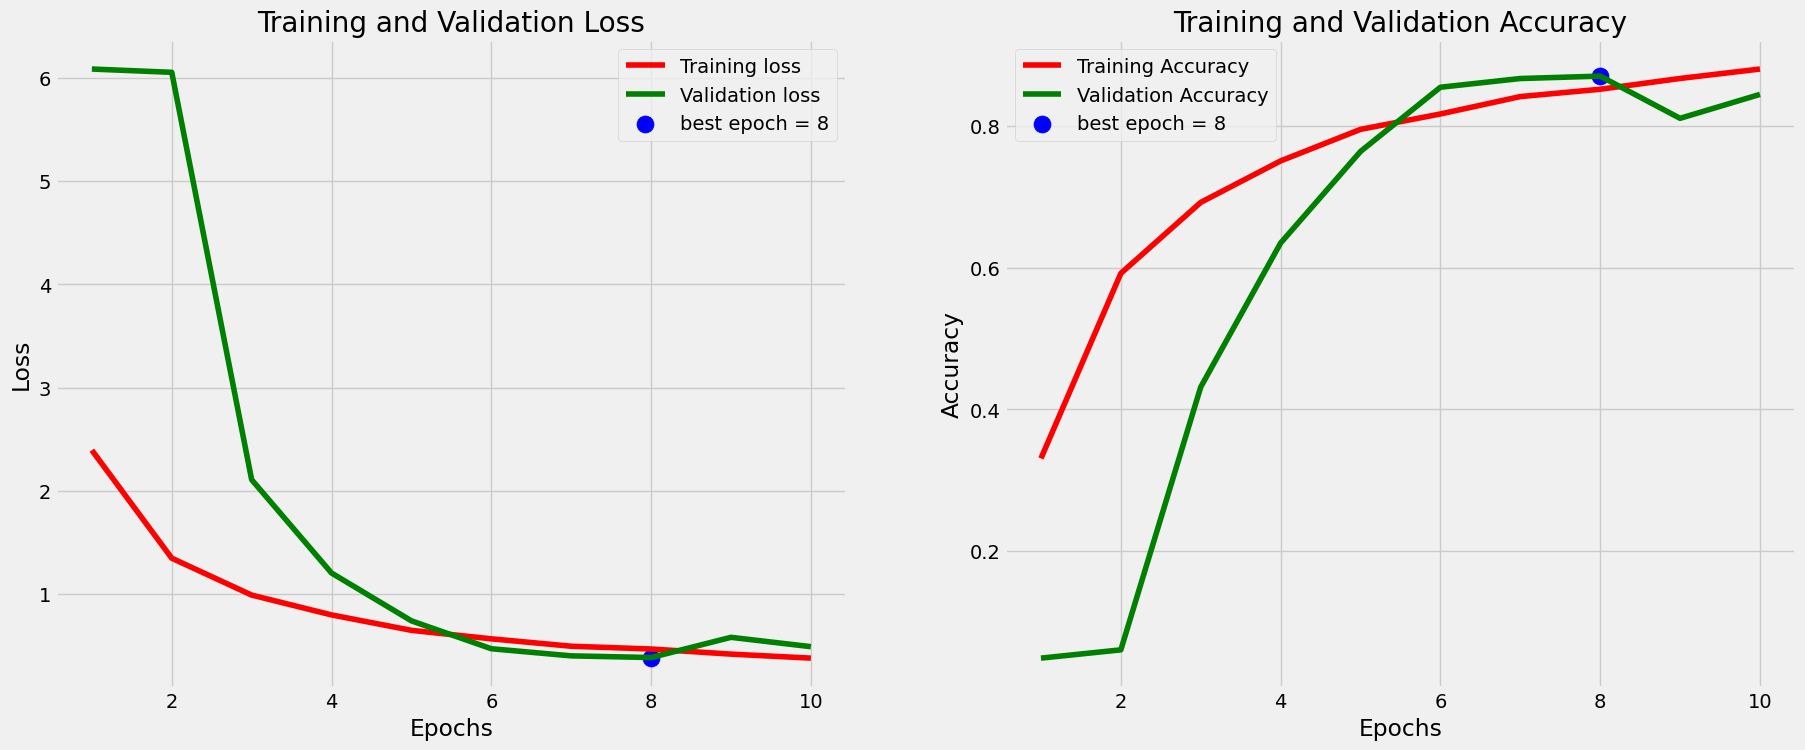

In [ ]:
tr_plot(cnn_fitted_model,0)

In [ ]:
print("Evaluate on test data")
results = model1.evaluate(test_generator, batch_size=128)
print("test loss, test acc:", results)


Evaluate on test data
176/176 [==============================] - 88s 500ms/step - loss: 0.4767 - accuracy: 0.8485
test loss, test acc: [0.47667714953422546, 0.848452091217041]


In [ ]:
model1.save("LD_cnn_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

In [ ]:
num_classes = 38

# Load pre-trained VGG16 model without top layers
vgg_base = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers so that they are not trainable
for layer in vgg_base.layers:
    layer.trainable = False

# Flatten the output of VGG16
flatten_output = Flatten()(vgg_base.output)

# Add your own fully connected layers for classification
dense1 = Dense(256, activation='relu')(flatten_output)
output_layer = Dense(num_classes, activation='softmax')(dense1)

# Create the model
model2 = Model(inputs=vgg_base.input, outputs=output_layer)

# Compile the model
model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
vgg16_fitted_model = model2.fit(training_generator,
                               steps_per_epoch  = 200,
                               epochs           = 10,
                               validation_data  = validation_generator,
                               validation_steps = 100)

Epoch 1/10
200/200 [==============================] - 200s 998ms/step - loss: 1.1139 - accuracy: 0.6757 - val_loss: 0.7049 - val_accuracy: 0.7781
Epoch 2/10
200/200 [==============================] - 205s 1s/step - loss: 0.5321 - accuracy: 0.8296 - val_loss: 0.5120 - val_accuracy: 0.8338
Epoch 3/10
200/200 [==============================] - 174s 872ms/step - loss: 0.4290 - accuracy: 0.8606 - val_loss: 0.4449 - val_accuracy: 0.8583
Epoch 4/10
200/200 [==============================] - 194s 970ms/step - loss: 0.3722 - accuracy: 0.8779 - val_loss: 0.4447 - val_accuracy: 0.8521
Epoch 5/10
200/200 [==============================] - 195s 976ms/step - loss: 0.3338 - accuracy: 0.8899 - val_loss: 0.4138 - val_accuracy: 0.8659
Epoch 6/10
200/200 [==============================] - 167s 834ms/step - loss: 0.3124 - accuracy: 0.8989 - val_loss: 0.3842 - val_accuracy: 0.8708
Epoch 7/10
200/200 [==============================] - 168s 840ms/step - loss: 0.3041 - accuracy: 0.8953 - val_loss: 0.3659 - va

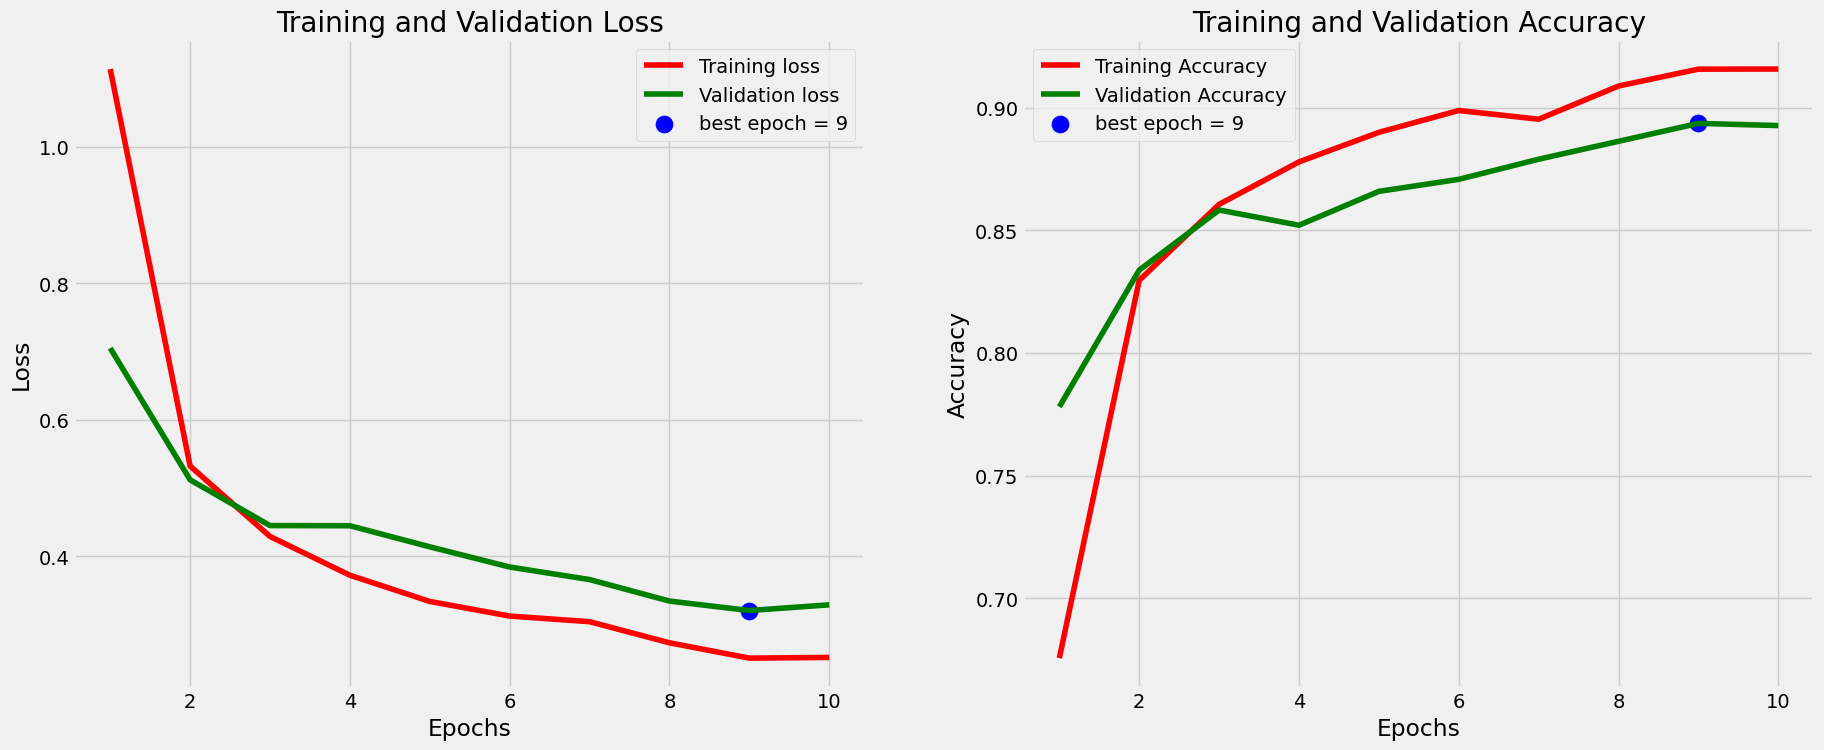

In [ ]:
tr_plot(vgg16_fitted_model,0)

In [ ]:
print("Evaluate on test data")
results2 = model2.evaluate(test_generator, batch_size=128)
print("test loss, test acc:", results2)

Evaluate on test data
176/176 [==============================] - 102s 582ms/step - loss: 0.3100 - accuracy: 0.8961
test loss, test acc: [0.3100407123565674, 0.8961415886878967]


In [ ]:
model2.save("LD_VGG16_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
num_classes = 38

# Load pre-trained MobileNetV2 model without top layers
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers so that they are not trainable
for layer in mobilenet_base.layers:
    layer.trainable = False

# Flatten the output of MobileNetV2
flatten_output = Flatten()(mobilenet_base.output)

# Add your own fully connected layers for classification
dense1 = Dense(256, activation='relu')(flatten_output)
output_layer = Dense(num_classes, activation='softmax')(dense1)

# Create the model
model3 = Model(inputs=mobilenet_base.input, outputs=output_layer)

# Compile the model
model3.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 2s 0us/step


In [ ]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']      

In [ ]:
MobileNetV2_fitted_model = model3.fit(training_generator,
                                      steps_per_epoch  = 200,
                                      epochs           = 10,
                                      validation_data  = validation_generator,
                                      validation_steps = 100)

Epoch 1/10
200/200 [==============================] - 167s 818ms/step - loss: 1.0322 - accuracy: 0.7583 - val_loss: 0.5666 - val_accuracy: 0.8349
Epoch 2/10
200/200 [==============================] - 186s 934ms/step - loss: 0.4160 - accuracy: 0.8724 - val_loss: 0.4595 - val_accuracy: 0.8593
Epoch 3/10
200/200 [==============================] - 160s 803ms/step - loss: 0.3085 - accuracy: 0.9029 - val_loss: 0.4571 - val_accuracy: 0.8656
Epoch 4/10
200/200 [==============================] - 158s 791ms/step - loss: 0.2888 - accuracy: 0.9103 - val_loss: 0.3733 - val_accuracy: 0.8874
Epoch 5/10
200/200 [==============================] - 186s 931ms/step - loss: 0.2664 - accuracy: 0.9166 - val_loss: 0.3802 - val_accuracy: 0.8901
Epoch 6/10
200/200 [==============================] - 187s 938ms/step - loss: 0.2446 - accuracy: 0.9226 - val_loss: 0.3718 - val_accuracy: 0.8955
Epoch 7/10
200/200 [==============================] - 185s 928ms/step - loss: 0.2242 - accuracy: 0.9305 - val_loss: 0.4034 -

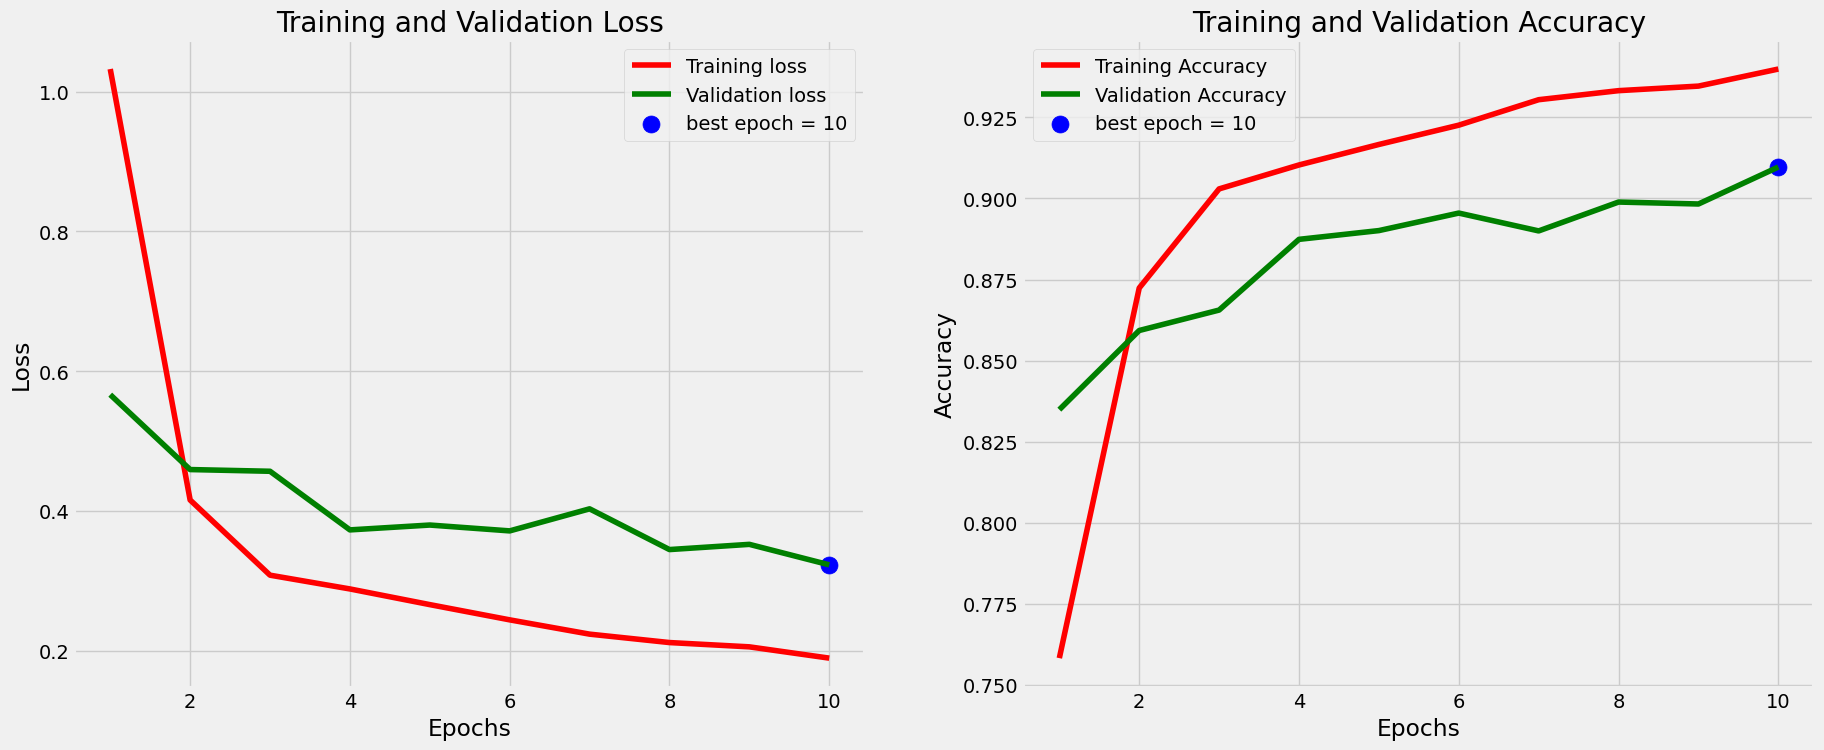

In [ ]:
tr_plot(MobileNetV2_fitted_model,0)

In [ ]:
print("Evaluate on test data")
results3 = model3.evaluate(test_generator, batch_size=128)
print("test loss, test acc:", results3)

Evaluate on test data
176/176 [==============================] - 98s 558ms/step - loss: 0.2908 - accuracy: 0.9183
test loss, test acc: [0.29079076647758484, 0.9183359742164612]


In [ ]:
model3.save("LD_MobileNetV2_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
final_results = np.array([['model      ','test loss', 'test acc'],
                          ['CNN        ', results[0],   results[1]],
                          ['VGG16      ', results2[0],  results2[1]],
                          ['MobileNetV2', results3[0],  results3[1]]])

In [ ]:
fr_df = df = pd.DataFrame(final_results)

In [ ]:
fr_df

,0,1,2
0,model,test loss,test acc
1,CNN,0.47667714953422546,0.848452091217041
2,VGG16,0.3100407123565674,0.8961415886878967
3,MobileNetV2,0.29079076647758484,0.9183359742164612


In [ ]:
gfg_csv_data = fr_df.to_csv('FinalResults.csv', index = False)